In [205]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression

In [206]:
# get data 

mouse_files = glob.glob('../logs/*mouse*.csv')
latency_files = glob.glob('../logs/*latency*.csv')
touchpad_files = glob.glob('../logs/*touchpad*.csv')
pose_files = glob.glob('../logs/*pose*.csv')

def create_dataframe(files):
    df = None
    for file in files:
        tmp_df = pd.read_csv(file)
        if df is None:
            df = tmp_df.copy()
        else:
            df = pd.concat([df, tmp_df], ignore_index=True)
    
    df.drop(df.columns[0], axis=1, inplace=True)
    return df

df_mouse = create_dataframe(mouse_files)
df_latency = create_dataframe(latency_files)
df_touchpad = create_dataframe(touchpad_files)
df_pose = create_dataframe(pose_files)

df_mouse

,id,trial,radius,distance,latency,hit,time,accuracy,click_x,click_y,target_x,target_y,click_time
0,1,0,25,110,0,True,5.611987,9.219544,467,356,460.000000,350.000000,1.719591e+09
1,1,0,25,110,0,True,0.760511,21.545008,231,294,250.893425,302.272789,1.719591e+09
2,1,0,25,110,0,True,0.900048,3.137435,421,434,418.583878,436.001463,1.719591e+09
3,1,0,25,110,0,True,0.991978,15.162062,329,228,325.522697,242.757930,1.719591e+09
4,1,0,25,110,0,True,0.700361,13.837017,327,471,325.522697,457.242070,1.719591e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2,2,50,180,0,True,0.816883,25.759210,288,188,309.946232,174.512976,1.719593e+09
185,2,2,50,180,0,True,0.751928,7.208806,317,524,309.946232,525.487024,1.719593e+09
186,2,2,50,180,0,True,0.708034,11.337054,461,198,462.228164,209.270333,1.719593e+09
187,2,2,50,180,0,True,0.730992,32.629257,206,401,187.825604,428.099073,1.719593e+09


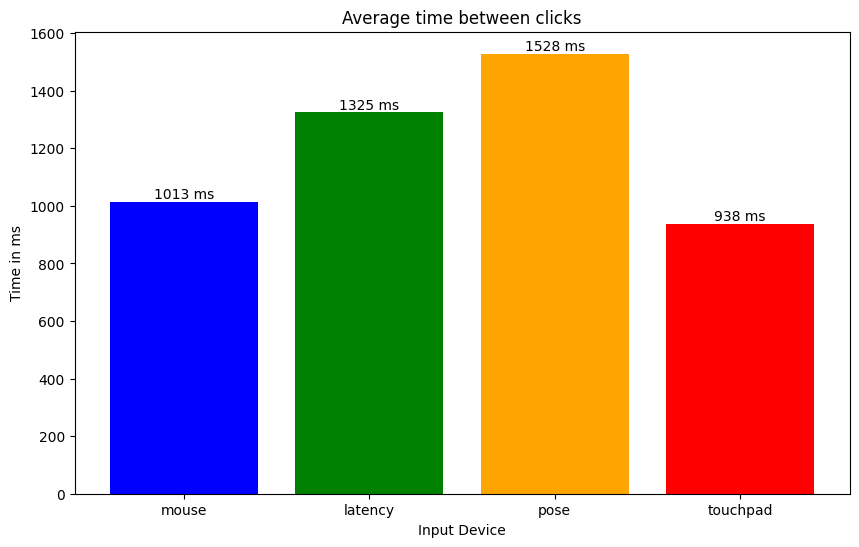

In [207]:
def calculate_average_movement_time(df):
    # s to ms
    df['time_ms'] = df['time'] * 1000
    return df['time_ms'].mean()


def calculate_average_movement_time_seconds(df):
    df['time_ms'] = df['time']
    return df['time_ms'].mean()


avg_speed_ms = {
    'mouse': calculate_average_movement_time(df_mouse),
    'latency': calculate_average_movement_time(df_latency),
    'pose': calculate_average_movement_time(df_pose),
    'touchpad': calculate_average_movement_time(df_touchpad)
}

avg_speed_s = {
    'mouse': calculate_average_movement_time_seconds(df_mouse),
    'latency': calculate_average_movement_time_seconds(df_latency),
    'pose': calculate_average_movement_time_seconds(df_pose),
    'touchpad': calculate_average_movement_time_seconds(df_touchpad)
}

plt.figure(figsize=(10, 6))
# ---------------------

dfs = list(avg_speed_ms.keys())
times = list(avg_speed_ms.values())

plt.bar(dfs, times, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Input Device')
plt.ylabel('Time in ms')
plt.title('Average time between clicks')

for key, time in enumerate(times):
    plt.text(key, time + 0.2, f'{int(time)} ms', ha='center', va='bottom', fontsize=10)

plt.show()

Intercept (a) of Regression mouse: -0.9488232970710646
Coefficient (b) of Regression mouse: 0.9483670068804405
Intercept (a) of Regression latency: -0.6938462870537132
Coefficient (b) of Regression latency: 0.9760368202333793
Intercept (a) of Regression pose: -0.3458008529023111
Coefficient (b) of Regression pose: 0.9057802594924711
Intercept (a) of Regression touchpad: -0.06127150308993479
Coefficient (b) of Regression touchpad: 0.4832490179629716


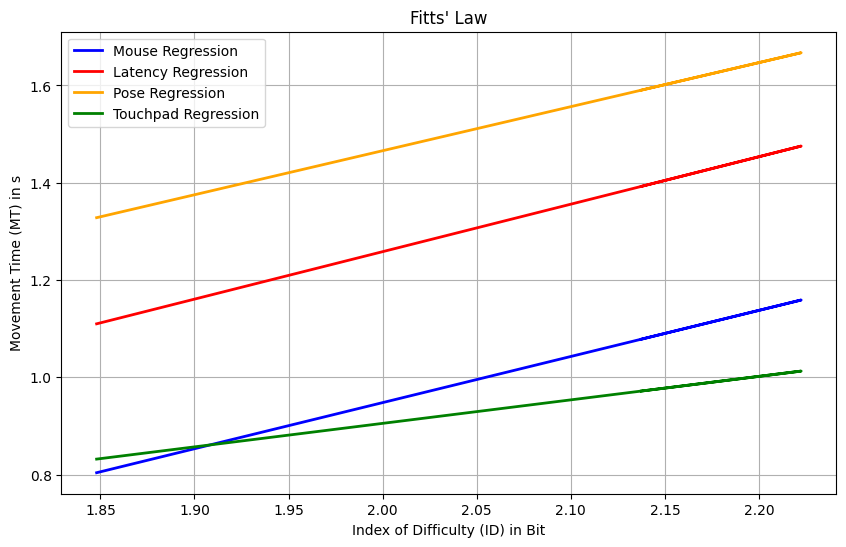

In [208]:
#  Index of difficulty Fits Law:
#  D = distance 
#  W = width = 2 * radius 
def calculate_ID(df):
    return np.log2(2 * df['distance'] / (df['radius'] * 2))

def calculae_MT(df, name):
    x = df['ID'].values.reshape(-1, 1)
    y = df['time'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Intercept (a) of Regression {name}: {regression.intercept_[0]}")
    print(f"Coefficient (b) of Regression {name}: {regression.coef_[0][0]}")
    return regression
    
df_mouse['ID'] = calculate_ID(df_mouse)
df_latency['ID'] = calculate_ID(df_latency)
df_pose['ID'] = calculate_ID(df_pose)
df_touchpad['ID'] = calculate_ID(df_touchpad)

MT_mouse = calculae_MT(df_mouse, 'mouse')
MT_latency = calculae_MT(df_latency, 'latency')
MT_pose = calculae_MT(df_pose, 'pose')
MT_touchpad = calculae_MT(df_touchpad, 'touchpad')

X_mouse = df_mouse['ID'].values.reshape(-1, 1)
y_mouse = df_mouse['time'].values.reshape(-1, 1)

X_latency = df_latency['ID'].values.reshape(-1, 1)
y_latency = df_latency['time'].values.reshape(-1, 1)

X_pose = df_pose['ID'].values.reshape(-1, 1)
y_pose = df_pose['time'].values.reshape(-1, 1)

X_touchpad = df_touchpad['ID'].values.reshape(-1, 1)
y_touchpad = df_touchpad['time'].values.reshape(-1, 1)


plt.figure(figsize=(10, 6))

# scatter plots for dfs (uncomment if you want to see!)
# plt.scatter(df_mouse['ID'], df_mouse['time'], marker='x', color='red', label='Mouse')
# plt.scatter(df_latency['ID'], df_latency['time'], marker='o', color='blue', label='Latency')
# plt.scatter(df_pose['ID'], df_pose['time'], marker='^', color='green', label='Pose')
# plt.scatter(df_touchpad['ID'], df_touchpad['time'], marker='s', color='orange', label='Touchpad')

plt.plot(X_mouse, MT_mouse.predict(X_mouse), color='blue', linewidth=2, label='Mouse Regression')
plt.plot(X_latency, MT_latency.predict(X_latency), color='red', linewidth=2, label='Latency Regression')
plt.plot(X_pose, MT_pose.predict(X_pose), color='orange', linewidth=2, label='Pose Regression')
plt.plot(X_touchpad, MT_touchpad.predict(X_touchpad), color='green', linewidth=2, label='Touchpad Regression')


plt.xlabel('Index of Difficulty (ID) in Bit')
plt.ylabel('Movement Time (MT) in s')
plt.title("Fitts' Law")
plt.grid(True)
plt.legend()
plt.show()

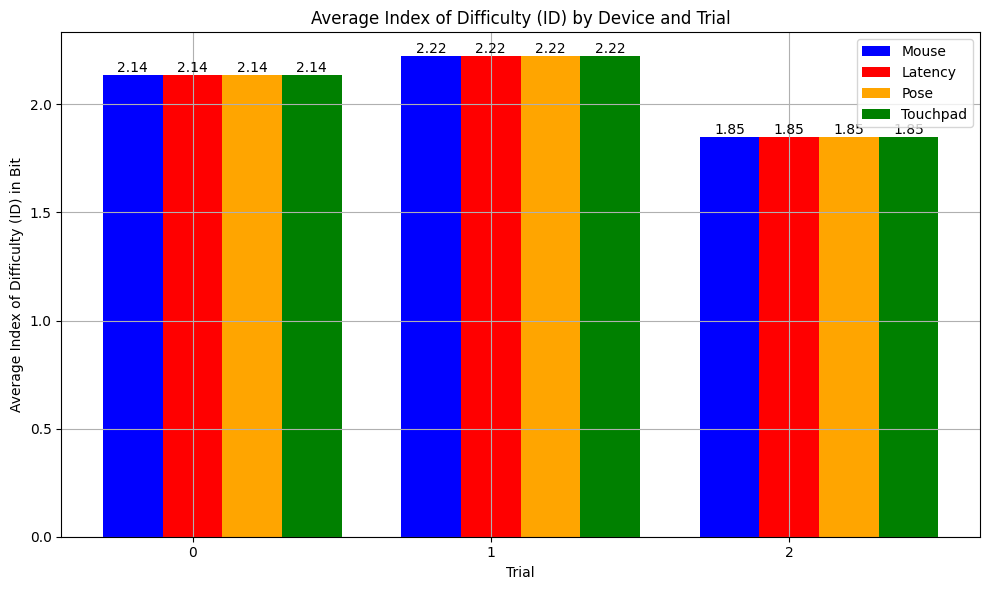

In [209]:

trials = df_mouse['trial'].unique()
dfs = {
    'Mouse': df_mouse,
    'Latency': df_latency,
    'Pose': df_pose,
    'Touchpad': df_touchpad
}

avg_ids = {device: [] for device in dfs.keys()}

# calculate average ID for each trial and device
for trial in trials:
    for device, df in dfs.items():
        avg_id = df[df['trial'] == trial]['ID'].mean()
        avg_ids[device].append(avg_id)

plt.figure(figsize=(10, 6))
bar_width = 0.1
index = np.arange(len(trials)) * (len(dfs) + 1) * bar_width  # adding extra space between groups


colors = ['blue', 'red', 'orange', 'green']

for i, (device, avg_values) in enumerate(avg_ids.items()):
    bar_positions = [x + i * bar_width for x in index]
    bars = plt.bar(bar_positions, avg_values, bar_width, label=device, color=colors[i])
    for bar, avg_value in zip(bars, avg_values):
        plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), f'{avg_value:.2f}', ha='center', va='bottom')


plt.xlabel('Trial')
plt.ylabel('Average Index of Difficulty (ID) in Bit')
plt.title('Average Index of Difficulty (ID) by Device and Trial')
plt.xticks([r + bar_width for r in index], trials)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

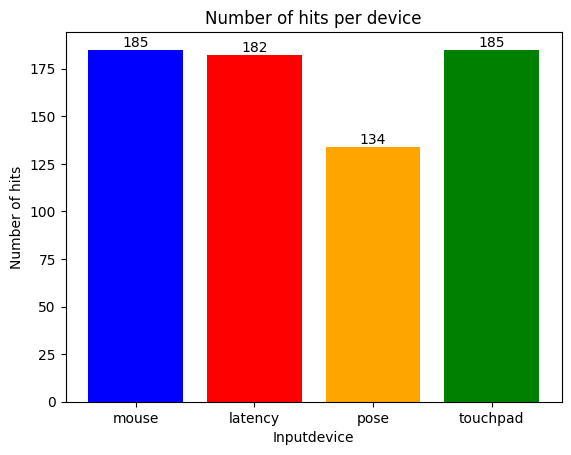

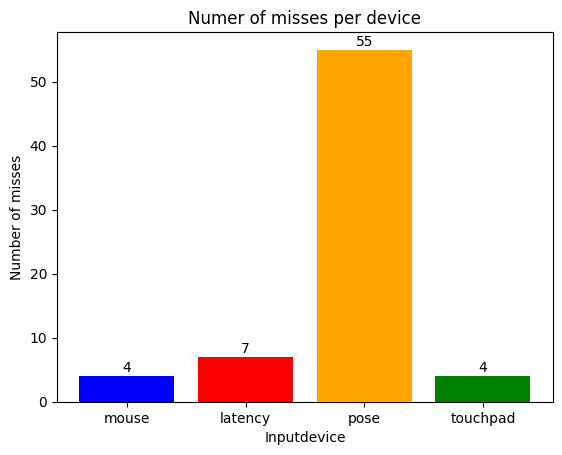

In [210]:
hit_counts = {
    'mouse': df_mouse[df_mouse['hit'] == True].shape[0],
    'latency': df_latency[df_latency['hit'] == True].shape[0],
    'pose': df_pose[df_pose['hit'] == True].shape[0],
    'touchpad': df_touchpad[df_touchpad['hit'] == True].shape[0]
}

miss_counts = {
    'mouse': df_mouse[df_mouse['hit'] == False].shape[0],
    'latency': df_latency[df_latency['hit'] == False].shape[0],
    'pose': df_pose[df_pose['hit'] == False].shape[0],
    'touchpad': df_touchpad[df_touchpad['hit'] == False].shape[0]
}

dfs = list(hit_counts.keys())
hits = list(hit_counts.values())

plt.bar(dfs, hits, color=['blue', 'red', 'orange', 'green'])
plt.xlabel('Inputdevice')
plt.ylabel('Number of hits')
plt.title('Number of hits per device')

for i, v in enumerate(hits):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom', fontsize=10)

plt.show()

# Erstellung des Bar-Charts für Fehler
dfs = list(miss_counts.keys())
miss = list(miss_counts.values())

plt.bar(dfs, miss, color=['blue', 'red', 'orange', 'green'])
plt.xlabel('Inputdevice')
plt.ylabel('Number of misses')
plt.title('Numer of misses per device')

# Text über den Balken hinzufügen
for i, v in enumerate(miss):
    plt.text(i, v + 0.2, str(v), ha='center', va='bottom', fontsize=10)

plt.show()


## Plot trial paths

In [211]:
def get_id_dfs(df):
    ids = df['id'].unique()
    id_dfs = {int(id_value): df[df['id'] == id_value] for id_value in ids}
    return id_dfs

def get_trials_from_ids(ids):
    res = {}
    for key, value in ids.items():
        trials = value['trial'].unique()
        trials = {int(trial): value[value['trial'] == trial] for trial in trials}
        res[key] = trials
    
    return res

def plot_trial_path(df):
    plt.figure(figsize=(10, 6))
    
    # Plotten der Pfade
    plt.plot(df['click_x'], df['click_y'], marker='o', linestyle='--')
    
    # Zeiten entlang der Pfade schreiben
    for i in range(len(df)-1):
        x1, y1 = df.iloc[i]['click_x'], df.iloc[i]['click_y']
        x2, y2 = df.iloc[i+1]['click_x'], df.iloc[i+1]['click_y']
        time = df.iloc[i+1]['time']
        # plt.text((x1 + x2) / 2, (y1 + y2) / 2, f'{time:.2f} s', fontsize=9, ha='right')
    
    radius = df['radius'].iloc[0]
    trial = df['trial'].iloc[0]
    
    plt.title(f'Trial {trial}  - Radius {radius}')
    plt.xlabel('click_x')
    plt.ylabel('click_y')
    plt.grid(True)
    plt.show()


mouse_ids = get_id_dfs(df_mouse)
latency_ids = get_id_dfs(df_latency)
touchpad_ids = get_id_dfs(df_touchpad)
pose_ids = get_id_dfs(df_pose)

mouse_trials = get_trials_from_ids(mouse_ids)
latency_trials = get_trials_from_ids(latency_ids)
touchpad_trials = get_trials_from_ids(touchpad_ids)
pose_trials = get_trials_from_ids(pose_ids)



Participant 1 ----------


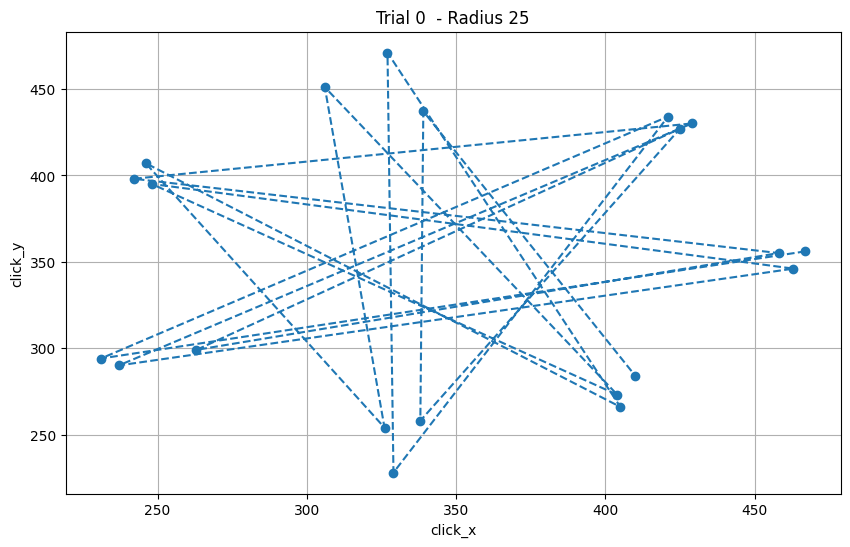

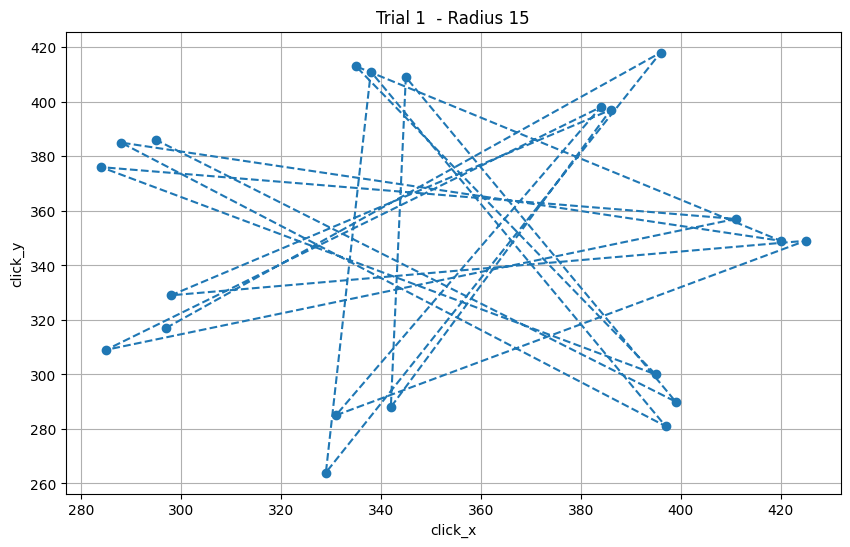

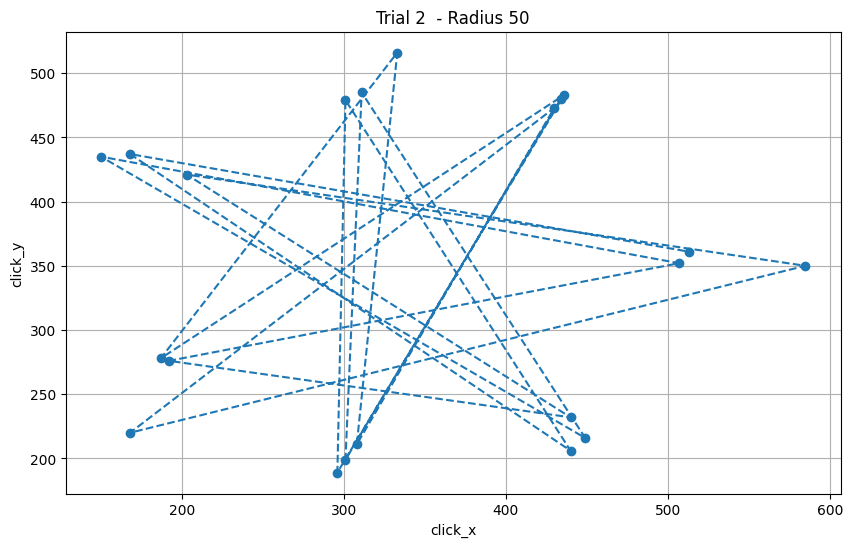

In [214]:
# print each users path for each trial 
# key = user id 
# value = trial
# if you want to see all participant remove the break 
#  or to call a specific participant call plot_trial_path(mouse_trials[0][0]) first [] = user id second [] = trial number
for key, value in mouse_trials.items():
    print(f'Participant {key} ----------')
    # v = number of trial 
    for v in value:
        plot_trial_path(mouse_trials[key][v])
    break
    